# 2025-02-12 Sparsity and solvers

## Last time

* Advection
* The (cell) Péclet number and oscillations
* Godunov's Theorem
* Cost of linear solvers

## Today

* _Questions_
* Assemblying sparse matrices
* Rootfinding and Newton's method for systems

In [16]:
using Plots
default(linewidth=3)
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_conservative(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) + wind * [.5 .5]
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) + wind * [.5 .5]
        js = i-1:i+1
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_conservative (generic function with 1 method)

# Some questions from class

1. What algorithm is Julia using for "`\`" (linear solve)?
2. What algorithm does Julia use for "`\`" if $A$ is sparse (random or banded)?
3. (from HW/portfolio) Why does the convergence rate of spectral methods decrease as the singularity gets closer?
4. Re-do upwind discretization with different differentiation stencil after having computed fluxes.


### 1. Algorithm for `\`

* It depends on what `A` is in `A\b`: [documentation](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#Base.:\\-Tuple{AbstractMatrix,%20AbstractVecOrMat})
* For nontriangular square matrices, use an LU factorization ($\approx$ Gaussian elimination):
    1. Factorize $PA = LU$ ($\mathcal{O}(n^3)$ operation, $P$ is a permutation matrix, $L$, $U$ are lower and upper triangular, resp.)
    2. solve $Ly = Pb$ for $y$ ($\mathcal{O}(n^2)$) 
    3. solve $Ux = y$ for $x$ ($\mathcal{O}(n^2)$) 
* But checks first if $A$ is lower or upper triangular, sparse, etc.
* For rectangular $A$, pivoted QR decomposition
* If you have to solve $Ax = b_1, b_2, \ldots$, worth taking decomposition of $A$ once and for all. 

### 2. Algorithm for sparse `\`

* [LinearAlgebra.jl](https://juliapackages.com/p/linearsolve) checks matrices for structure and picks the best linear solve 
  * Factorizations: LU, QR, Cholesky, ...
  * Also includes iterative methods (for very large matrices, when you can only do $A v$ due to memory limitations)
* [A good summary](https://people.eecs.berkeley.edu/~demmel/cs267_Spr15/Lectures/lecture15_SparseDirectSolvers_short_Grigori.pdf)
* Guiding principles:
  1. Store nonzero elements (compressed sparse formats, _today_)
  2. Only compute flops on nonzero elements
  3. Exploit parallelism due to sparsity of matrix

### 3. Error in spectral interpolation

* For polynomial approximation $p_n$ of functions $f$ analytic on $[-1, 1]$, the convergence rate is determined by how large a neighborhood in the complex plane they can be analytically continued to 
* Neighborhood that matter are Bernstein ellipses $E_{\rho}$:
  * Imagine $z = e^{i\theta}$ circle with radius $\rho > 1$ in complex $z$-plane
  * Transform as $x = (z + z^{-1})/2$ $\to$ get ellipse in complex $x$-plane with foci $-1, 1$ (shown on board)
  * Annulus $\rho^{-1} < |z| < \rho$ gets mapped to $E_{\rho}$
  

  
* Thm 8.1 - 8.2 in Trefethen's _Approximation Theory, approximation practice_:
  * If $f$ is analytic in $[-1, 1]$ and is analytically continuable to the open Bernstein ellipse $E_{\rho}$, where it satisfies $|f(x)| \leq M$ for some $M$, then
  * Chebyshev interpolant $p_n$ satisfies 
  
  $$|| f - p_n || \leq \frac{4M\rho^{-n}}{\rho -1}$$

**Questions**:
* What does the converence rate look like (e.g. $\mathcal{O}(n^{-p})$, $\mathcal{O}(c^{-n})$, something else)? What variable(s) does the rate depend on?
* How does the convergence rate change with changing $\rho$?
* What might prevent us from increasing $\rho$ ad infinitum? Think: what does $f(x) = x^2$ look in the complex plane? How about $f(x) = e^x$? How about $f(x) = \frac{1}{1 - 0.5x^2}$? 

### 4. Upwind discretization

# Experiments, The (cell) [Péclet number](https://en.wikipedia.org/wiki/P%C3%A9clet_number)

\begin{align}
\big(wu - \kappa u_x\big)_x &= f & \mathrm{Pe}_h &= \frac{h \lvert w \rvert}{\kappa}
\end{align}

minimum(diff(x)) = 0.06896551724137923


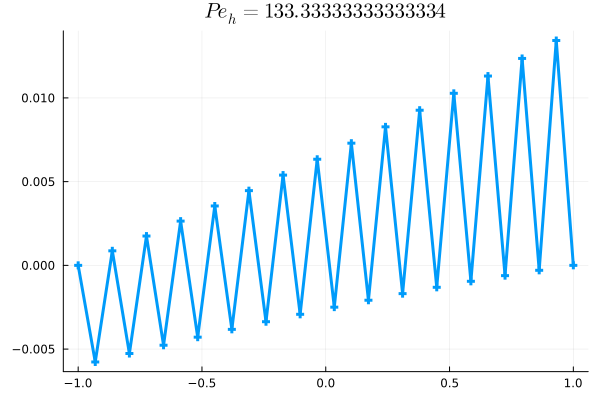

In [30]:
n = 30; h = 2/n
kappa = .1
wind = 200
x, L, rhs = advdiff_conservative(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="\$Pe_h = $(wind*h/kappa)\$")

In [31]:
function advdiff_upwind(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        js = i-1:i+1
        # Note the difference here!
        if i != n-1
            weights = fdstencil(xstag[i-1:i+1], x[i], 1)
        else
            weights = fdstencil(xstag[i-1:i], x[i], 1)
        end
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_upwind (generic function with 1 method)

# Upwinded discretization for robustness

Idea: incoming **advective flux** should depend only on upwind value, outgoing should depend only on my value.

minimum(diff(x)) = 0.006688963210702281


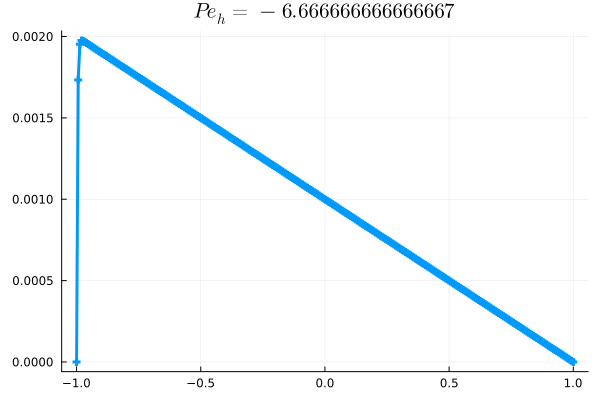

In [33]:
n = 300; h = 2/n
kappa = 1
wind = -1000
x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="\$Pe_h = $(wind*h/kappa)\$")

# How expensive is `\`?

In [34]:
x, L, rhs = advdiff_upwind(1000, x -> kappa, wind, one)
@timev L \ rhs;

  0.022932 seconds (9 allocations: 7.641 MiB, 18.69% gc time)
elapsed time (ns):  2.2931992e7
gc time (ns):       4286776
bytes allocated:    8012240
pool allocs:        6
non-pool GC allocs: 0
malloc() calls:     3
free() calls:       49
minor collections:  1
full collections:   0


In [50]:
function elapsed_solve(n)
    x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
    @elapsed L \ rhs
end
ns = (1:6) * 1000
times = elapsed_solve.(ns)

6-element Vector{Float64}:
 0.01267134
 0.063942318
 0.205584677
 0.459547307
 0.775472146
 1.280012286

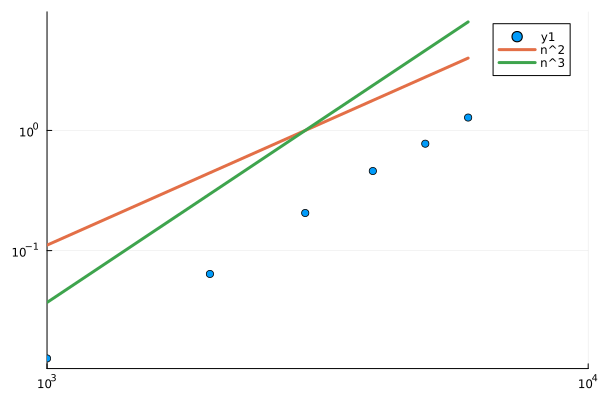

In [51]:
scatter(ns, times, xscale=:log10, yscale=:log10)
plot!(ns, [(ns/3000).^2, (ns/3000).^3], label=["n^2" "n^3"], xrange=(1e3, 1e4))

## How long would $n=10000$ take to solve?

## How much memory would $n=10000$ take?

# Sparsity

# How does solving with the sparse matrix scale?

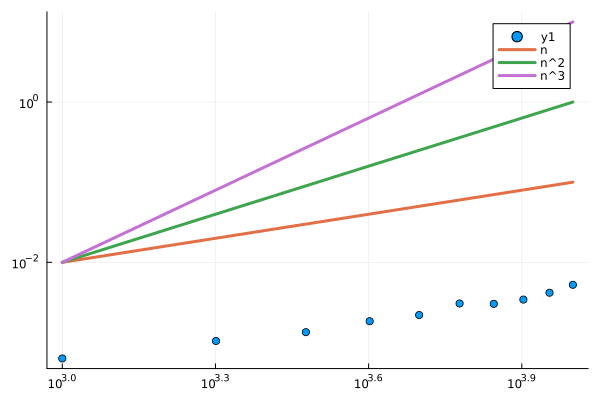

In [56]:
function elapsed_solve(n)
    x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
    L = sparse(L)
    @elapsed L \ x
end
ns = (1:10) * 1000
times = elapsed_solve.(ns)
scatter(ns, times, xscale=:log10, yscale=:log10)
plot!([n -> 1e-2*n/1000, n -> 1e-2*(n/1000)^2, n -> 1e-2*(n/1000)^3],
  label=["n" "n^2" "n^3"])

## How much memory is needed?

# [SparseArrays](https://docs.julialang.org/en/v1/stdlib/SparseArrays/) Compressed Sparse Column (CSC)

In [36]:
using SparseArrays
# starting with a dense matrix
A = sparse([1 0 0 -2; 0 3.14 0 .4; 5.1 0 0 .06])

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅     ⋅   -2.0
  ⋅   3.14   ⋅    0.4
 5.1   ⋅     ⋅    0.06

In [37]:
@show A.colptr # Column j is in colptr[j]:(colptr[j+1]-1)
@show A.rowval # Row indices of stored values
A.nzval # Nonzero elements

A.colptr = [1, 3, 4, 4, 7]
A.rowval = [1, 3, 2, 1, 2, 3]


6-element Vector{Float64}:
  1.0
  5.1
  3.14
 -2.0
  0.4
  0.06

* CSC (or, more commonly outside Matlab/Julia, row-based CSR) are good for matrix operations (multiplication, solve), but sometimes inconvenient to assemble.
* When? Accessing by rows, insertion of an entry

# Matrix assembly using [COO](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_.28COO.29) format

In [38]:
A

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅     ⋅   -2.0
  ⋅   3.14   ⋅    0.4
 5.1   ⋅     ⋅    0.06

In [40]:
sparse([1, 1, 2, 2, 3, 3],
       [1, 4, 2, 4, 1, 4],
       [1, -2, 3.14, .4, 5.1, .06])

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅     ⋅   -2.0
  ⋅   3.14   ⋅    0.4
 5.1   ⋅     ⋅    0.06

# Upwind advection-diffusion solver using COO

In [20]:
function advdiff_sparse(n, kappa, wind, forcing; rightbc=0)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    rhs[[1,n]] = [0, rightbc] # Dirichlet boundary condition
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights[1] *  [flux_L..., 0] + weights[2] * [0, flux_R...])
    end
    L = sparse(rows, cols, vals)
    x, L, rhs
end

advdiff_sparse (generic function with 1 method)

# Assembly cost

minimum(diff(x)) = 0.005012531328320691


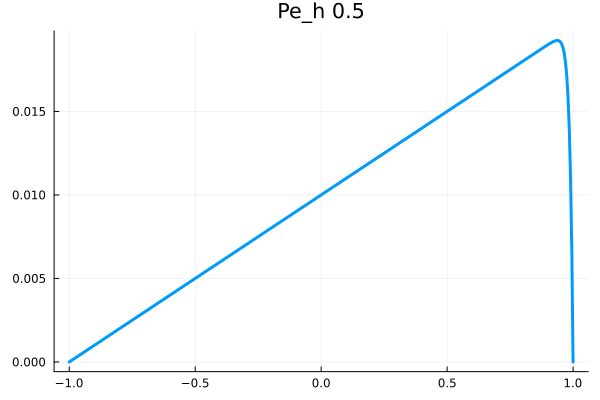

In [41]:
n = 400; h = 2/n
kappa = 1
wind = 100
x, L, rhs = advdiff_sparse(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, legend=:none, title="Pe_h $(wind*h/kappa)")

In [42]:
n = 10000
@time advdiff_upwind(n, one, 1, one);
@time advdiff_sparse(n, one, 1, one);

  0.354588 seconds (1.03 M allocations: 799.073 MiB, 2.30% gc time)
  0.038911 seconds (978.88 k allocations: 37.378 MiB)


In [44]:
# It's also possible to dynamically insert.
# (But performance this way is generally poor.)
A = spzeros(5, 5)
A[1,1] = 3
A

5×5 SparseMatrixCSC{Float64, Int64} with 1 stored entry:
 3.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 

# Nonlinear problems and rootfinding

We want to solve problems like
$$ -(|u_x|^{p-2} u_x)_x + (u^2)_x = 0 $$

For linear problems, we found $u$ such that $L u = b$ using linear algebra.

For nonlinear problems, we'll need to find $u$ such that $F(u) = 0$.

# An algorithm: Bisection

Bisection is a rootfinding technique that starts with an interval $[a,b]$ containing a root and does not require derivatives. Suppose $f$ is continuous. What is a **sufficient** condition for $f$ to have a root on $[a,b]$?

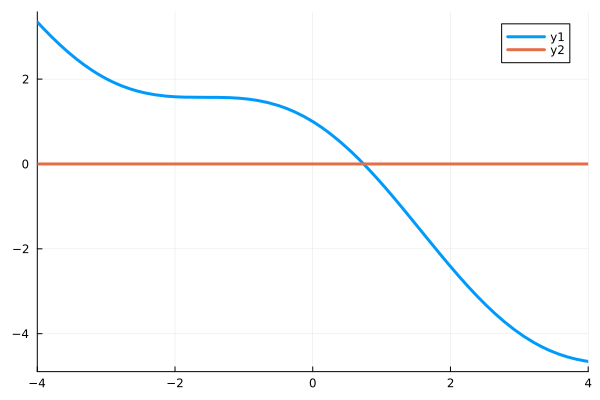

In [46]:
hasroot(f, a, b) = f(a) * f(b) < 0

f(x) =  cos(x) - x
plot([f, x->0], xlims=(-4,4))

In [47]:
hasroot(f, 0, 1)

true

# Bisection

In [48]:
function bisect(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return mid
    elseif hasroot(f, a, mid)
        return bisect(f, a, mid, tol)
    else
        return bisect(f, mid, b, tol)
    end
end

x0 = bisect(f, -1, 3, 1e-5)
x0, f(x0)

(0.7390861511230469, -1.7035832658995886e-6)

# How fast does it converge?

In [49]:
function bisect_hist(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return [mid]
    elseif hasroot(f, a, mid)
        return prepend!(bisect_hist(f, a, mid, tol), [mid])
    else
        return prepend!(bisect_hist(f, mid, b, tol), [mid])
    end
end

bisect_hist (generic function with 1 method)

In [50]:
bisect_hist(f, -1, 3, 1e-4)

17-element Vector{Float64}:
 1.0
 0.0
 0.5
 0.75
 0.625
 0.6875
 0.71875
 0.734375
 0.7421875
 0.73828125
 0.740234375
 0.7392578125
 0.73876953125
 0.739013671875
 0.7391357421875
 0.73907470703125
 0.739105224609375

# Let's plot the error

$$ \lvert \texttt{bisect}^k(f, a, b) - r \rvert, \quad k = 1, 2, \dotsc $$

where $r$ is the true root, $f(r) = 0$.

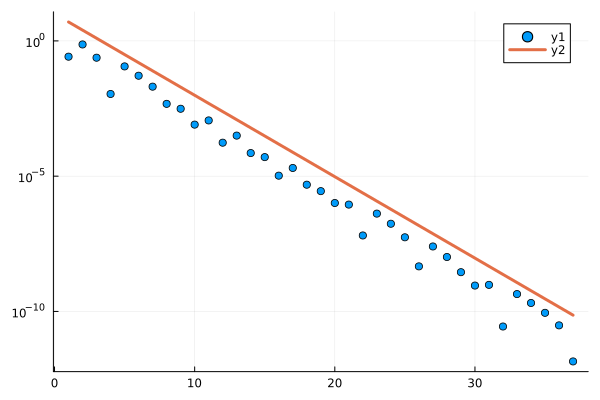

In [51]:
r = bisect(f, -1, 3, 1e-14) # what are we trusting?
hist = bisect_hist(f, -1, 3, 1e-10)
scatter( abs.(hist .- r), yscale=:log10)
ks = 1:length(hist)
plot!(ks, 10 * 0.5 .^ ks)

Evidently the error $e_k = x_k - x_*$ after $k$ bisections satisfies the bound
$$ |e^k| \le c 2^{-k} . $$

# Convergence classes

A convergent rootfinding algorithm produces a sequence of approximations $x_k$ such that $$\lim_{k \to \infty} x_k \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_k = x_k - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if $$\lim_{k \to \infty} |e_{k+1}| / |e_k| = \rho < 1.$$  (The $q$ is for "quotient".)  A smaller convergence factor $\rho$ represents faster convergence.  A slightly weaker condition ($r$-linear convergence or just **linear convergence**) is that
$$ |e_k| \le \epsilon_k $$
for all sufficiently large $k$ when the sequence $\{\epsilon_k\}$ converges $q$-linearly to 0.

## Bisection: A = q-linearly convergent, B = r-linearly convergent, C = neither

# Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* Roots of even degree are problematic
* A bound on the solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy
* **No good generalization to higher dimensions**

## Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

# An implementation

In [52]:
function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("[$k] x=$x  f(x)=$fx  f'(x)=$fpx")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end
eps = 1e-1
newton(x -> eps*(cos(x) - x), x -> eps*(-sin(x) - 1), 1; tol=1e-15, verbose=true)

[1] x=1  f(x)=-0.04596976941318603  f'(x)=-0.18414709848078967
[2] x=0.7503638678402439  f(x)=-0.0018923073822117442  f'(x)=-0.16819049529414878
[3] x=0.7391128909113617  f(x)=-4.645589899077152e-6  f'(x)=-0.16736325442243014
[4] x=0.739085133385284  f(x)=-2.8472058044570758e-11  f'(x)=-0.16736120293089507
[5] x=0.7390851332151607  f(x)=0.0  f'(x)=-0.1673612029183215


(0.7390851332151607, 0.0, 5)

# That's really fast!

* 10 digits of accuracy in 4 iterations.
* How is this convergence test different from the one we used for bisection?
* How can this break down?

$$ x_{k+1} = x_k - f(x_k)/f'(x_k) $$

In [28]:
newton(x -> cos(x) - x, x -> -sin(x) - 1, 0.2*pi/2; verbose=true)

[1] x=0.3141592653589793  f(x)=0.6368972509361742  f'(x)=-1.3090169943749475
[2] x=0.8007054703914749  f(x)=-0.10450500785604744  f'(x)=-1.7178474183038182
[3] x=0.7398706100060081  f(x)=-0.0013148113494647617  f'(x)=-1.6741923555416478
[4] x=0.7390852693340639  f(x)=-2.2781024078266654e-7  f'(x)=-1.6736121297866664
[5] x=0.7390851332151648  f(x)=-6.8833827526759706e-15  f'(x)=-1.673612029183218


(0.7390851332151648, -6.8833827526759706e-15, 5)